## Novartis Data Science Hiring challenge
- https://www.hackerearth.com/challenges/hiring/novartis-data-science-hiring-challenge/

![title](data/pic1.png)

## ProblemStatement

![title](data/pic.png)

![title](data/pic2.png)

In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

pd.set_option('display.max_columns', None)

In [33]:
def add_noise(series, noise_level):
    return series * (1 + noise_level * np.random.randn(len(series)))

def target_encode(trn_series=None, 
                  tst_series=None, 
                  target=None, 
                  min_samples_leaf=1, 
                  smoothing=1,
                  noise_level=0):
    """
    Smoothing is computed like in the following paper by Daniele Micci-Barreca
    trn_series : training categorical feature as a pd.Series
    tst_series : test categorical feature as a pd.Series
    target : target data as a pd.Series
    min_samples_leaf (int) : minimum samples to take category average into account
    smoothing (int) : smoothing effect to balance categorical average vs prior  
    """ 
    assert len(trn_series) == len(target)
    assert trn_series.name == tst_series.name
    temp = pd.concat([trn_series, target], axis=1)
    # Compute target mean 
    averages = temp.groupby(by=trn_series.name)[target.name].agg(["mean", "count"])
    # Compute smoothing
    smoothing = 1 / (1 + np.exp(-(averages["count"] - min_samples_leaf) / smoothing))
    # Apply average function to all target data
    prior = target.mean()
    # The bigger the count the less full_avg is taken into account
    averages[target.name] = prior * (1 - smoothing) + averages["mean"] * smoothing
    averages.drop(["mean", "count"], axis=1, inplace=True)
    # Apply averages to trn and tst series
    ft_trn_series = pd.merge(
        trn_series.to_frame(trn_series.name),
        averages.reset_index().rename(columns={'index': target.name, target.name: 'average'}),
        on=trn_series.name,
        how='left')['average'].rename(trn_series.name + '_mean').fillna(prior)
    # pd.merge does not keep the index so restore it
    ft_trn_series.index = trn_series.index 
    ft_tst_series = pd.merge(
        tst_series.to_frame(tst_series.name),
        averages.reset_index().rename(columns={'index': target.name, target.name: 'average'}),
        on=tst_series.name,
        how='left')['average'].rename(trn_series.name + '_mean').fillna(prior)
    # pd.merge does not keep the index so restore it
    ft_tst_series.index = tst_series.index
    return add_noise(ft_trn_series, noise_level), add_noise(ft_tst_series, noise_level)

In [2]:
def create_date_featues(df):

    df['Year'] = pd.to_datetime(df['DateTime']).dt.year

    df['Month'] = pd.to_datetime(df['DateTime']).dt.month

    df['Day'] = pd.to_datetime(df['DateTime']).dt.day

    df['Dayofweek'] = pd.to_datetime(df['DateTime']).dt.dayofweek

    df['DayOfyear'] = pd.to_datetime(df['DateTime']).dt.dayofyear

    df['Week'] = pd.to_datetime(df['DateTime']).dt.week

    df['Quarter'] = pd.to_datetime(df['DateTime']).dt.quarter 

    df['Is_month_start'] = pd.to_datetime(df['DateTime']).dt.is_month_start

    df['Is_month_end'] = pd.to_datetime(df['DateTime']).dt.is_month_end

    df['Is_quarter_start'] = pd.to_datetime(df['DateTime']).dt.is_quarter_start

    df['Is_quarter_end'] = pd.to_datetime(df['DateTime']).dt.is_quarter_end

    df['Is_year_start'] = pd.to_datetime(df['DateTime']).dt.is_year_start

    df['Is_year_end'] = pd.to_datetime(df['DateTime']).dt.is_year_end

    df['Semester'] = np.where(df['Quarter'].isin([1,2]),1,2)

    df['Is_weekend'] = np.where(df['Dayofweek'].isin([5,6]),1,0)

    df['Is_weekday'] = np.where(df['Dayofweek'].isin([0,1,2,3,4]),1,0)

    #df['Days_in_month'] = pd.to_datetime(df['DateTime']).dt.days_in_month
    
    df['Hour'] = pd.to_datetime(df['DateTime']).dt.hour
    
    #df['Time'] = [((date.hour*60+(date.minute))*60)+date.second for date in df.DateTime]

    return df

In [39]:
df=pd.read_csv('train.csv',parse_dates=['DATE'])
test=pd.read_csv('test.csv',parse_dates=['DATE'])
df.head(10)

,INCIDENT_ID,DATE,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,X_9,X_10,X_11,X_12,X_13,X_14,X_15,MULTIPLE_OFFENSE
0,CR_102659,2004-07-04,0,36,34,2,1,5,6,1,6,1,174,1.0,92,29,36,0
1,CR_189752,2017-07-18,1,37,37,0,0,11,17,1,6,1,236,1.0,103,142,34,1
2,CR_184637,2017-03-15,0,3,2,3,5,1,0,2,3,1,174,1.0,110,93,34,1
3,CR_139071,2009-02-13,0,33,32,2,1,7,1,1,6,1,249,1.0,72,29,34,1
4,CR_109335,2005-04-13,0,33,32,2,1,8,3,0,5,1,174,0.0,112,29,43,1
5,CR_96263,2003-04-07,0,45,45,10,3,1,0,1,6,1,303,1.0,72,62,34,1
6,CR_131400,2008-01-22,0,30,35,7,3,7,1,0,5,1,174,0.0,112,29,43,1
7,CR_11981,1993-05-14,0,8,7,7,3,9,8,0,5,1,316,1.0,72,62,34,1
8,CR_184134,2016-08-21,0,49,49,6,5,8,3,1,1,1,316,1.0,103,14,34,1
9,CR_32634,1996-08-25,1,4,4,6,5,15,10,0,5,2,145,1.0,103,29,34,0


In [40]:
df.columns=df.columns.str.lower()
test.columns=test.columns.str.lower()

In [5]:
df.isnull().sum()/len(df.index)

incident_id         0.000000
date                0.000000
x_1                 0.000000
x_2                 0.000000
x_3                 0.000000
x_4                 0.000000
x_5                 0.000000
x_6                 0.000000
x_7                 0.000000
x_8                 0.000000
x_9                 0.000000
x_10                0.000000
x_11                0.000000
x_12                0.007629
x_13                0.000000
x_14                0.000000
x_15                0.000000
multiple_offense    0.000000
dtype: float64

In [42]:
test.isnull().sum()

incident_id      0
date             0
x_1              0
x_2              0
x_3              0
x_4              0
x_5              0
x_6              0
x_7              0
x_8              0
x_9              0
x_10             0
x_11             0
x_12           127
x_13             0
x_14             0
x_15             0
dtype: int64

In [43]:
df.x_12.fillna(0,inplace=True)
test.x_12.fillna(0,inplace=True)

In [44]:
test.drop('incident_id',axis=1,inplace=True)
df.drop('incident_id',axis=1,inplace=True)

In [45]:
df.rename({'date':'DateTime'},axis=1,inplace=True)
test.rename({'date':'DateTime'},axis=1,inplace=True)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23856 entries, 0 to 23855
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   DateTime          23856 non-null  datetime64[ns]
 1   x_1               23856 non-null  int64         
 2   x_2               23856 non-null  int64         
 3   x_3               23856 non-null  int64         
 4   x_4               23856 non-null  int64         
 5   x_5               23856 non-null  int64         
 6   x_6               23856 non-null  int64         
 7   x_7               23856 non-null  int64         
 8   x_8               23856 non-null  int64         
 9   x_9               23856 non-null  int64         
 10  x_10              23856 non-null  int64         
 11  x_11              23856 non-null  int64         
 12  x_12              23856 non-null  float64       
 13  x_13              23856 non-null  int64         
 14  x_14              2385

In [46]:
create_date_featues(df)
create_date_featues(test)

,DateTime,x_1,x_2,x_3,x_4,x_5,x_6,x_7,x_8,x_9,...,Is_month_start,Is_month_end,Is_quarter_start,Is_quarter_end,Is_year_start,Is_year_end,Semester,Is_weekend,Is_weekday,Hour
0,2018-02-01,0,30,35,7,3,6,4,0,5,...,True,False,False,False,False,False,1,0,1,0
1,2004-03-05,0,44,44,1,3,7,1,4,6,...,False,False,False,False,False,False,1,0,1,0
2,2018-01-27,0,34,33,3,5,2,7,3,0,...,False,False,False,False,False,False,1,1,0,0
3,2006-08-18,7,3,2,3,5,9,8,0,5,...,False,False,False,False,False,False,2,0,1,0
4,2011-10-31,0,7,8,7,3,2,7,1,5,...,False,True,False,False,False,False,2,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15898,1997-11-28,1,22,22,7,3,15,10,0,5,...,False,False,False,False,False,False,2,0,1,0
15899,2012-06-09,0,35,30,3,5,1,0,2,3,...,False,False,False,False,False,False,1,1,0,0
15900,2006-04-22,0,26,27,9,0,6,4,2,6,...,False,False,False,False,False,False,1,1,0,0
15901,2009-04-03,0,21,23,4,1,2,7,1,6,...,False,False,False,False,False,False,1,0,1,0


In [11]:
df.Is_month_start.value_counts(dropna=False)

False    22910
True       946
Name: Is_month_start, dtype: int64

In [47]:
df.columns

Index(['DateTime', 'x_1', 'x_2', 'x_3', 'x_4', 'x_5', 'x_6', 'x_7', 'x_8',
       'x_9', 'x_10', 'x_11', 'x_12', 'x_13', 'x_14', 'x_15',
       'multiple_offense', 'Year', 'Month', 'Day', 'Dayofweek', 'DayOfyear',
       'Week', 'Quarter', 'Is_month_start', 'Is_month_end', 'Is_quarter_start',
       'Is_quarter_end', 'Is_year_start', 'Is_year_end', 'Semester',
       'Is_weekend', 'Is_weekday', 'Hour'],
      dtype='object')

In [38]:
x=df.drop(['multiple_offense'],axis=1)
y=df['multiple_offense']

In [37]:
column=['x_1', 'x_2', 'x_3', 'x_4', 'x_5', 'x_6', 'x_7', 'x_8','x_9', 'x_10', 'x_11', 'x_12', 'x_13', 'x_14', 'x_15']

In [68]:
for col in column:
    df[col+'_me'],test[col+'_me']=target_encode(df[col], test[col], target=df.multiple_offense, 
                                                    min_samples_leaf=100,smoothing=10, noise_level=0.01)
    

In [70]:
df.head()

,DateTime,x_1,x_2,x_3,x_4,x_5,x_6,x_7,x_8,x_9,x_10,x_11,x_12,x_13,x_14,x_15,multiple_offense,Year,Month,Day,Dayofweek,DayOfyear,Week,Quarter,Is_month_start,Is_month_end,Is_quarter_start,Is_quarter_end,Is_year_start,Is_year_end,Semester,Is_weekend,Is_weekday,Hour,col_me,x_1_me,x_2_me,x_3_me,x_4_me,x_5_me,x_6_me,x_7_me,x_8_me,x_9_me,x_10_me,x_11_me,x_12_me,x_13_me,x_14_me,x_15_me
0,2004-07-04,0,36,34,2,1,5,6,1,6,1,174,1.0,92,29,36,0,2004,7,4,6,186,27,3,False,False,False,False,False,False,2,1,0,0,0.000263,0.952748,0.940338,0.929781,0.956624,0.956717,0.959742,0.953964,0.955245,0.958825,0.988651,0.972093,0.952260,0.972426,0.983646,0.000264
1,2017-07-18,1,37,37,0,0,11,17,1,6,1,236,1.0,103,142,34,1,2017,7,18,1,199,29,3,False,False,False,False,False,False,2,0,1,0,0.966243,0.946894,0.932257,0.942406,0.957097,0.973815,0.944607,0.938795,0.965875,0.944800,0.986363,0.946308,0.950951,0.941907,0.950957,0.967101
2,2017-03-15,0,3,2,3,5,1,0,2,3,1,174,1.0,110,93,34,1,2017,3,15,2,74,11,1,False,False,False,False,False,False,1,0,1,0,0.980684,0.950195,0.989253,0.981324,0.949786,0.978338,0.941953,0.958261,0.942941,0.910557,0.992678,0.960604,0.969399,0.973482,0.956734,0.957040
3,2009-02-13,0,33,32,2,1,7,1,1,6,1,249,1.0,72,29,34,1,2009,2,13,4,44,7,1,False,False,False,False,False,False,1,0,1,0,0.963732,0.950137,1.013804,1.008971,0.951425,0.958405,0.958047,0.960454,0.960596,0.960511,0.979346,1.007305,0.973466,0.950386,0.972887,0.958948
4,2005-04-13,0,33,32,2,1,8,3,0,5,1,174,0.0,112,29,43,1,2005,4,13,2,103,15,2,False,False,False,False,False,False,1,0,1,0,0.973961,0.975342,0.996912,1.016830,0.971121,0.957625,0.948624,0.946854,0.944856,0.962291,0.985879,0.959134,0.978549,0.982885,0.970984,0.991873


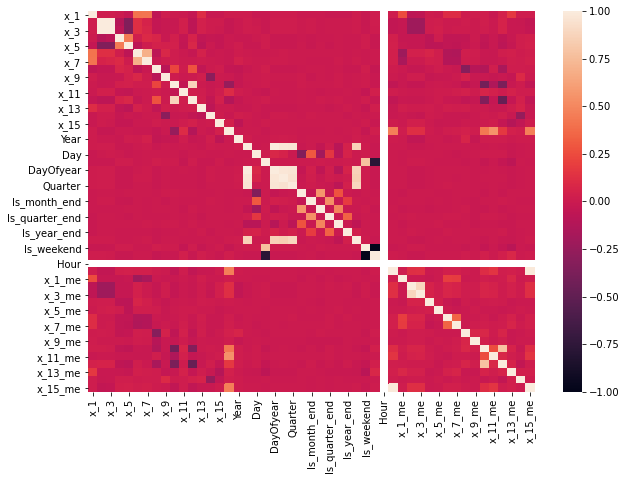

In [71]:
fig=plt.figure(figsize=(10,7))
sns.heatmap(df.corr())

In [129]:
df.corr()['multiple_offense'].sort_values(ascending=False)

multiple_offense    1.000000
x_11_me             0.554438
col_me              0.464760
x_15_me             0.463897
x_10_me             0.434506
x_12_me             0.167839
x_3_me              0.122882
x_2_me              0.117704
x_11                0.105088
x_15                0.044916
x_13_me             0.041051
x_8_me              0.041001
x_7_me              0.026753
Is_weekday          0.024040
x_14_me             0.023846
x_1_me              0.022685
x_9_me              0.020681
x_6_me              0.017471
x_1                 0.014034
Semester            0.011412
x_4_me              0.010614
DayOfyear           0.007173
Week                0.007037
Month               0.006736
x_13                0.006512
Is_quarter_end      0.005380
Quarter             0.004886
Day                 0.004736
Is_year_end         0.000747
x_9                -0.000748
x_5_me             -0.001320
Is_month_start     -0.002751
Year               -0.002755
Is_month_end       -0.002784
x_4           

In [157]:
col=['multiple_offense','x_11_me','x_15_me','x_10_me','x_12_me','x_3_me','x_2_me',
     'x_11','x_15','x_13_me','x_8_me','x_7_me','Is_weekday','x_14_me','x_1_me','x_9_me',
     'x_6_me','x_1','Semester','x_4_me','DayOfyear','Week','Month','x_13','Is_quarter_end',
     'Quarter','Day','Is_year_end']

In [134]:
df=df[col]

In [137]:
x=df.drop(['multiple_offense'],axis=1)
y=df['multiple_offense']

In [138]:
x.head()

,x_11_me,x_15_me,x_10_me,x_12_me,x_3_me,x_2_me,x_11,x_15,x_13_me,x_8_me,x_7_me,Is_weekday,x_14_me,x_1_me,x_9_me,x_6_me,x_1,Semester,x_4_me,DayOfyear,Week,Month,x_13,Is_quarter_end,Quarter,Day,Is_year_end
0,0.972093,0.000264,0.988651,0.952260,0.929781,0.940338,174,36,0.972426,0.955245,0.953964,0,0.983646,0.952748,0.958825,0.959742,0,2,0.956624,186,27,7,92,False,3,4,False
1,0.946308,0.967101,0.986363,0.950951,0.942406,0.932257,236,34,0.941907,0.965875,0.938795,1,0.950957,0.946894,0.944800,0.944607,1,2,0.957097,199,29,7,103,False,3,18,False
2,0.960604,0.957040,0.992678,0.969399,0.981324,0.989253,174,34,0.973482,0.942941,0.958261,1,0.956734,0.950195,0.910557,0.941953,0,1,0.949786,74,11,3,110,False,1,15,False
3,1.007305,0.958948,0.979346,0.973466,1.008971,1.013804,249,34,0.950386,0.960596,0.960454,1,0.972887,0.950137,0.960511,0.958047,0,1,0.951425,44,7,2,72,False,1,13,False
4,0.959134,0.991873,0.985879,0.978549,1.016830,0.996912,174,43,0.982885,0.944856,0.946854,1,0.970984,0.975342,0.962291,0.948624,0,1,0.971121,103,15,4,112,False,2,13,False


In [139]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import Normalizer

In [140]:
ct = ColumnTransformer([("norm1", Normalizer(norm='l1'),col)],remainder='passthrough')
a=ct.fit_transform(x)

In [142]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x, y, train_size=0.7 , random_state=100)

In [248]:
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from xgboost import XGBClassifier

In [144]:
from sklearn.metrics import classification_report

In [145]:
xgb=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1, colsample_bytree=0.8, 
                  gamma=1.5, learning_rate=0.05, max_delta_step=0, max_depth=3, 
                  min_child_weight=7, missing=None,
                  n_estimators=100, n_jobs=-1, 
                  nthread=None, objective='binary:logistic',
                  random_state=0, reg_alpha=0, reg_lambda=1, 
                  scale_pos_weight=1, seed=None, silent=True, subsample=0.6)

In [146]:
xgb.fit(X_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=1.5, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.05, max_delta_step=0, max_depth=3,
              min_child_weight=7, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=-1, nthread=-1, num_parallel_tree=1,
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=0, silent=True, subsample=0.6, tree_method=None,
              validate_parameters=False, verbosity=None)

In [148]:
pred1=xgb.predict(X_test)
pred1

array([1, 1, 0, ..., 1, 1, 1], dtype=int64)

In [149]:
print(classification_report(y_test,pred1))

              precision    recall  f1-score   support

           0       0.98      0.92      0.95       313
           1       1.00      1.00      1.00      6844

    accuracy                           1.00      7157
   macro avg       0.99      0.96      0.97      7157
weighted avg       1.00      1.00      1.00      7157



In [150]:
test.head()

,DateTime,x_1,x_2,x_3,x_4,x_5,x_6,x_7,x_8,x_9,x_10,x_11,x_12,x_13,x_14,x_15,Year,Month,Day,Dayofweek,DayOfyear,Week,Quarter,Is_month_start,Is_month_end,Is_quarter_start,Is_quarter_end,Is_year_start,Is_year_end,Semester,Is_weekend,Is_weekday,Hour,col_me,x_1_me,x_2_me,x_3_me,x_4_me,x_5_me,x_6_me,x_7_me,x_8_me,x_9_me,x_10_me,x_11_me,x_12_me,x_13_me,x_14_me,x_15_me
0,2018-02-01,0,30,35,7,3,6,4,0,5,1,174,0.0,72,119,23,2018,2,1,3,32,5,1,True,False,False,False,False,False,1,0,1,0,1.010425,0.965987,0.882610,0.898935,0.964183,0.951766,0.952713,0.979826,0.955338,0.968206,1.002906,0.983969,0.981387,0.959399,0.963167,1.004131
1,2004-03-05,0,44,44,1,3,7,1,4,6,1,316,0.0,12,29,34,2004,3,5,4,65,10,1,False,False,False,False,False,False,1,0,1,0,0.952864,0.954190,0.956382,0.941701,0.944427,0.965947,0.966198,0.947290,0.918837,0.951555,0.995492,0.991493,0.989864,0.965713,0.954848,0.972806
2,2018-01-27,0,34,33,3,5,2,7,3,0,1,316,1.0,72,0,34,2018,1,27,5,27,4,1,False,False,False,False,False,False,1,1,0,0,0.984945,0.937371,0.966740,0.947489,0.948122,0.949141,0.982722,0.960170,0.923156,0.969194,0.993830,1.004348,0.962481,0.966986,0.966833,0.967295
3,2006-08-18,7,3,2,3,5,9,8,0,5,1,174,1.0,112,87,34,2006,8,18,4,230,33,3,False,False,False,False,False,False,2,0,1,0,0.969029,0.969568,0.973564,0.957541,0.962246,0.931821,0.966810,0.989388,0.951914,0.966799,0.989183,0.964954,0.975516,0.974927,0.959776,0.980642
4,2011-10-31,0,7,8,7,3,2,7,1,5,1,174,0.0,112,93,43,2011,10,31,0,304,44,4,False,True,False,False,False,False,2,0,1,0,0.997128,0.943386,0.994232,1.000853,0.969814,0.943951,0.958371,0.943450,0.959735,0.948156,0.983946,0.961493,0.979062,0.984246,0.960338,1.008759


In [158]:
col_test=col=['x_11_me','x_15_me','x_10_me','x_12_me','x_3_me','x_2_me',
     'x_11','x_15','x_13_me','x_8_me','x_7_me','Is_weekday','x_14_me','x_1_me','x_9_me',
     'x_6_me','x_1','Semester','x_4_me','DayOfyear','Week','Month','x_13','Is_quarter_end',
     'Quarter','Day','Is_year_end']

In [154]:
test_new=test[col_test]
test_new.head()

,x_11_me,x_15_me,x_10_me,x_12_me,x_3_me,x_2_me,x_11,x_15,x_13_me,x_8_me,x_7_me,Is_weekday,x_14_me,x_1_me,x_9_me,x_6_me,x_1,Semester,x_4_me,DayOfyear,Week,Month,x_13,Is_quarter_end,Quarter,Day,Is_year_end
0,0.983969,1.004131,1.002906,0.981387,0.898935,0.882610,174,23,0.959399,0.955338,0.979826,1,0.963167,0.965987,0.968206,0.952713,0,1,0.964183,32,5,2,72,False,1,1,False
1,0.991493,0.972806,0.995492,0.989864,0.941701,0.956382,316,34,0.965713,0.918837,0.947290,1,0.954848,0.954190,0.951555,0.966198,0,1,0.944427,65,10,3,12,False,1,5,False
2,1.004348,0.967295,0.993830,0.962481,0.947489,0.966740,316,34,0.966986,0.923156,0.960170,0,0.966833,0.937371,0.969194,0.982722,0,1,0.948122,27,4,1,72,False,1,27,False
3,0.964954,0.980642,0.989183,0.975516,0.957541,0.973564,174,34,0.974927,0.951914,0.989388,1,0.959776,0.969568,0.966799,0.966810,7,2,0.962246,230,33,8,112,False,3,18,False
4,0.961493,1.008759,0.983946,0.979062,1.000853,0.994232,174,43,0.984246,0.959735,0.943450,1,0.960338,0.943386,0.948156,0.958371,0,2,0.969814,304,44,10,112,False,4,31,False


In [156]:
pred=xgb.predict(test_new)
pred

array([1, 1, 1, ..., 1, 1, 1], dtype=int64)

In [216]:
pred_df=pd.DataFrame(pred,columns=['pred'])
pred_df.head()

,pred
0,1
1,1
2,1
3,1
4,1


In [198]:
import os
os.listdir()

['.ipynb_checkpoints',
 'sample_submission.csv',
 'Test.csv',
 'Train.csv',
 'Untitled.ipynb']

In [199]:
sub=pd.read_csv('sample_submission.csv')
sub

,INCIDENT_ID,MULTIPLE_OFFENSE
0,CR_195453,1
1,CR_103520,0
2,.,.
3,.,.
4,CR_196089,1
5,CR_112195,0
6,CR_149832,1


In [235]:
import gc
gc.collect()

488

In [237]:
final=pd.read_csv('test.csv')
final.tail()

,INCIDENT_ID,DATE,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,X_9,X_10,X_11,X_12,X_13,X_14,X_15
15898,CR_44468,28-NOV-97,1,22,22,7,3,15,10,0,5,1,174,0.0,72,29,43
15899,CR_158460,09-JUN-12,0,35,30,3,5,1,0,2,3,2,0,2.0,72,93,34
15900,CR_115946,22-APR-06,0,26,27,9,0,6,4,2,6,1,0,1.0,72,62,34
15901,CR_137663,03-APR-09,0,21,23,4,1,2,7,1,6,2,249,2.0,92,62,34
15902,CR_33545,24-APR-96,0,4,4,6,5,4,2,5,6,1,249,1.0,72,29,34


In [239]:
assert len(final) == len(pred_df)

In [240]:
submit=pd.DataFrame()

In [241]:

submit['INCIDENT_ID']=test_n['INCIDENT_ID']

In [243]:
submit['MULTIPLE_OFFENSE']=pred_df['pred']

In [246]:
submit.head(9)

,INCIDENT_ID,MULTIPLE_OFFENSE
0,CR_195453,1
1,CR_103520,1
2,CR_196089,1
3,CR_112195,1
4,CR_149832,1
5,CR_81654,1
6,CR_139009,1
7,CR_6108,1
8,CR_62283,1


In [245]:
submit.to_csv('submit.csv',index=False)

In [252]:
pred_df['pred'].value_counts()

1    15216
0      687
Name: pred, dtype: int64